### Load Libraries

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
#from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
import json
from tqdm import tqdm
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from IPython.display import display
import ipywidgets as widgets
import ipyevents
from PIL import Image
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random

### Load COCO data

In [ ]:
# === Paths ===

png_folder = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Chinook6/images/default"
jpeg_folder = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Chinook6/images/jpeg_files"
coco_json_path = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Chinook6/annotations/instances_default.json"
updated_json_path = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Chinook6/annotations/instances_default_jpeg.json"
jpeg_enhanced_folder = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Chinook6/images/jpeg_background_subtracted"

In [69]:
with open(updated_json_path) as f:
    coco = json.load(f)

# Map image_id to image metadata
image_id_to_data = {img["id"]: img for img in coco["images"]}

In [ ]:
## Convert PNGs to JPEG and update COCO JSON
os.makedirs(jpeg_folder, exist_ok=True)

# === 1. Convert PNGs to JPEG and rename ===
filename_map = {}  # maps old filename to new filename
for filename in os.listdir(png_folder):
    if filename.endswith(".png") and filename.startswith("frame_"):
        old_path = os.path.join(png_folder, filename)
        new_filename = filename.replace("frame_", "").replace(".png", ".jpg")
        new_path = os.path.join(jpeg_folder, new_filename)

        img = Image.open(old_path).convert("RGB")
        img.save(new_path, "JPEG", quality=95)

        filename_map[filename] = new_filename

# === 2. Update COCO JSON ===
with open(coco_json_path, "r") as f:
    coco = json.load(f)

for image in coco["images"]:
    old_filename = image["file_name"]
    if old_filename in filename_map:
        image["file_name"] = filename_map[old_filename]

# === 3. Save updated JSON ===
with open(updated_json_path, "w") as f:
    json.dump(coco, f, indent=2)

print(f"✅ Done! Saved JPEGs to '{jpeg_folder}' and updated COCO JSON to '{updated_json_path}'")


In [ ]:
## Function for getting annotation index
def get_annotation_indices_for_frame(coco, image_id):
    """
    Returns the indices of all annotations for the specified image_id (frame).
    
    Parameters:
        coco (dict): COCO-style dictionary with "annotations".
        image_id (int): ID of the image (frame) to find annotations for.
    
    Returns:
        List[int]: Indices of matching annotations in coco["annotations"].
    """
    indices = [i for i, ann in enumerate(coco["annotations"]) if ann["image_id"] == image_id]
    return indices

### Try Background removal

In [ ]:
# Paths
image_dir = jpeg_folder
jpeg_enhanced_folder = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Chinook6/images/jpeg_background_subtracted"
output_dir = jpeg_enhanced_folder
os.makedirs(output_dir, exist_ok=True)

# Collect annotated image IDs
annotated_ids = {ann["image_id"] for ann in coco1["annotations"]}

# Map file names to image IDs
id_to_filename = {img["id"]: img["file_name"] for img in coco1["images"]}
filename_to_id = {v: k for k, v in id_to_filename.items()}

# Identify background image filenames (no annotations)
background_files = [
    fname for fname in id_to_filename.values()
    if filename_to_id[fname] not in annotated_ids
]

print(f"Found {len(background_files)} background images.")

# Read background images and compute mean
background_images = []

for fname in tqdm(background_files, desc="Loading background frames"):
    path = os.path.join(image_dir, fname)
    img = cv2.imread(path).astype(np.float32) / 255.0  # Normalize
    background_images.append(img)

mean_background = np.mean(background_images, axis=0)

# Subtract background from all images and save
all_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(".jpg")])

def get_motion_mask(prev_img, curr_img):
    prev_gray = cv2.cvtColor((prev_img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor((curr_img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(curr_gray, prev_gray)

    # Optional: Blur and threshold to clean up
    #diff_blur = cv2.GaussianBlur(diff, (5, 5), 0)
    #_, motion_mask = cv2.threshold(diff_blur, 15, 255, cv2.THRESH_BINARY)

    # Expand to 3 channels and normalize to [0, 1]
    motion_mask_color = cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR).astype(np.float32) / 255.0
    return motion_mask_color

prev_img = None

for fname in tqdm(all_files, desc="Subtracting and saving images"):
    img_path = os.path.join(image_dir, fname)
    out_path = os.path.join(output_dir, fname)

    img = cv2.imread(img_path).astype(np.float32) / 255.0
    # 1. Subtract background
    #img_bg_removed = img - mean_background
    #img_bg_removed = np.clip(img_bg_removed, 0, 1)
    img_bg_removed = img

    # 2. Contrast stretch
    min_val = img_bg_removed.min()
    max_val = img_bg_removed.max()
    if max_val > min_val:
        img_stretched = (img_bg_removed - min_val) / (max_val - min_val)
    else:
        img_stretched = img_bg_removed  # avoid divide by zero

    # if prev_img is not None:
    #     # 3. Motion mask
    #     # Use the motion mask to enhance the contrast of the current image
    #     # by adding it to the stretched image.
    #     # This is a simple way to enhance the image based on motion.
    #     # You can adjust the weight of the motion mask as needed.
    #     motion_mask = get_motion_mask(prev_img, img) if prev_img is not None else None
    #     img_stretched = np.clip(img_stretched + 0.5 * motion_mask, 0, 1)

    img_uint8 = (img_stretched * 255).astype(np.uint8)
    # 3. CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l2 = clahe.apply(l)
    lab_clahe = cv2.merge((l2, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # 4. Bilateral Filter (denoise while preserving edges)
    img_denoised = cv2.bilateralFilter(img_clahe, d=9, sigmaColor=30, sigmaSpace=50)

    # 5. Sharpen
    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    img_sharpened = cv2.filter2D(img_denoised, -1, kernel_sharp)

    prev_img = img

    cv2.imwrite(out_path, img_sharpened)

print(f"✅ Done! Background-subtracted images saved to {output_dir}")


Found 77 background images.


Subtracting and saving images: 100%|██████████| 211/211 [00:05<00:00, 35.35it/s]

✅ Done! Background-subtracted images saved to /Users/simone/Documents/UofT MSc/CaltechFishCounting/Chinook6/images/jpeg_background_subtracted


### Creat inference state

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
elif device.type == "cpu":
    torch.autocast("cpu", dtype=torch.bfloat16).__enter__()

#torch.set_float32_matmul_precision('high')

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [ ]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [32]:
inference_state = predictor.init_state(video_path=jpeg_enhanced_folder)#, offload_state_to_cpu=True, offload_video_to_cpu=True)

frame loading (JPEG): 100%|██████████| 211/211 [00:05<00:00, 36.31it/s]


In [ ]:
## Functions for plotting masks from propagate masks SAM function
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
# Update mask for one frame
ann = coco["annotations"][5]
ann_frame_idx = ann["image_id"] - 1
ann_obj_id = ann["attributes"]["track_id"]
x, y, w, h = ann["bbox"]
bbox = np.array([[x, y, x + w, y + h]])
image_info = image_id_to_data[ann["image_id"]]
# ann_frame_idx = 50  # the frame index we interact with
# ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
# points = np.array([[600, 700]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
# labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=bbox
    # points=points,
    # labels=labels,
)


In [ ]:
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join("/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/coho_brow_trout/images/jpeg_files", image_info["file_name"])))
#show_box(bbox, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# Plot single mask
mask_tensor = out_mask_logits[0].cpu().numpy()[0]  # Move tensor to CPU and convert to NumPy array
binary_mask = (mask_tensor > 0).astype(np.uint8)  # Assuming thresholding at 0
binary_mask_fortran = np.asfortranarray(binary_mask)
rle = mask_utils.encode(binary_mask_fortran)
rle["counts"] = rle["counts"].decode("utf-8")

def decode_rle(rle):
    if isinstance(rle['counts'], str):
        rle['counts'] = rle['counts'].encode('utf-8')
    return mask_utils.decode(rle)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join("/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/coho_brow_trout/images/jpeg_files", image_info["file_name"])))

mask = decode_rle(rle)
plt.imshow(np.ma.masked_where(mask == 0, mask), alpha=0.4)

In [ ]:
# Generate masks from bounding boxes (original code)
for ann in tqdm(coco["annotations"]):
    ann_frame_idx = ann["image_id"] - 1
    ann_obj_id = ann["attributes"]["track_id"]
    # Convert COCO bbox (x, y, width, height) → SAM format (x0, y0, x1, y1)
    x, y, w, h = ann["bbox"]
    bbox = np.array([[x, y, x + w, y + h]])

    # Predict the mask
    _, out_obj_ids, masks = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box = bbox,
    )

    # Convert PyTorch tensor to NumPy array and then to uint8
    mask_id = out_obj_ids.index(ann_obj_id)
    # binary_mask = masks[mask_id].cpu().numpy()[0].astype(np.uint8)
    # # Make sure it's Fortran-contiguous as required
    # rle = mask_utils.encode(np.asfortranarray(binary_mask))
    # rle["counts"] = rle["counts"].decode("utf-8")

    # Example tensor output from the model (ensure it's on CPU for processing)
    mask_tensor = masks[mask_id].cpu().numpy()[0]  # Move tensor to CPU and convert to NumPy array

    # Step 1: Convert to binary mask
    # If your mask values are in the range of -1024 and positive values, threshold them to 1 (mask) and 0 (background)
    binary_mask = (mask_tensor > 0).astype(np.uint8)  # Assuming thresholding at 0

    # Step 2: Ensure the binary mask is Fortran-contiguous as required by pycocotools
    binary_mask_fortran = np.asfortranarray(binary_mask)

    # Step 3: Run-length encode the binary mask
    rle = mask_utils.encode(binary_mask_fortran)

    # Step 4: Make the RLE counts JSON-serializable by decoding bytes
    rle["counts"] = rle["counts"].decode("utf-8")

    # Add to annotation
    ann["segmentation"] = rle
    ann["iscrowd"] = 0  # Required when using RLE format

In [ ]:
# Plot of one mask
rle = coco["annotations"][1]["segmentation"]
mask = mask_utils.decode(rle)
masked = np.ma.masked_where(mask == 0, mask)
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join("/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/coho_brow_trout/images/jpeg_files", image_info["file_name"])))
plt.imshow(masked, alpha=0.7)
plt.show()

### Predict Masks using SAM2 (uncompressed RLE... list of pixels)

In [39]:
def sam_mask_to_uncompressed_rle(mask_tensor):
    """
    Converts a SAM2 mask tensor (shape [1, H, W]) into COCO uncompressed RLE.
    """
    # Step 1: Convert to binary mask (uint8, 0/1)
    binary_mask = (mask_tensor > 0).astype(np.uint8)  # Threshold at 0

    # Step 2: Fortran-contiguous layout (required by pycocotools)
    binary_mask_fortran = np.asfortranarray(binary_mask)

    # Step 3: Encode to RLE (compressed by default)
    rle = mask_utils.encode(binary_mask_fortran)

    # Step 4: Convert counts from bytes to list (uncompressed-style for COCO/YTVIS)
    rle["counts"] = list(rle["counts"])
    
    return rle


In [208]:
predictor.reset_state(inference_state)

In [70]:
# Prepare to collect updated segmentations
#subset_coco = coco["annotations"][0:25]

for ann in tqdm(coco["annotations"]):
    ann_frame_idx = ann["image_id"] - 1
    ann_obj_id = ann["attributes"]["track_id"]
    
    # Convert COCO bbox (x, y, width, height) → SAM format (x0, y0, x1, y1)
    x, y, w, h = ann["bbox"]
    bbox = np.array([[x, y, x + w, y + h]])

    # Predict the mask
    _, out_obj_ids, masks = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        box=bbox,
    )
    
    # Convert PyTorch tensor to NumPy array and then to uint8
    mask_id = out_obj_ids.index(ann_obj_id)

    # Example tensor output from the model (ensure it's on CPU for processing)
    mask_tensor = masks[mask_id].cpu().numpy()[0]  # Move tensor to CPU and convert to NumPy array

    rle = sam_mask_to_uncompressed_rle(mask_tensor)    

    # Add to annotation
    ann["segmentation"] = rle
    ann["iscrowd"] = 0  # Required when using RLE format


  0%|          | 0/134 [00:00<?, ?it/s]/Users/simone/Documents/UofT MSc/CaltechFishCounting/.venv/lib/python3.11/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/simone/Documents/UofT MSc/CaltechFishCounting/.venv/lib/python3.11/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
100%|██████████| 134/134 [03:48<00:00,  1.70s/it]


In [ ]:
## Save to new JSON file
box_json_path = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Chinook6/annotations/instances_default_box_rle.json"
with open(box_json_path, "w") as f:
    json.dump(coco, f, indent=2)

In [ ]:
# === Build category_id → name mapping and assign a unique color to each ===
categories = {cat["id"]: cat["name"] for cat in coco["categories"]}
category_colors = {
    cat_id: color for cat_id, color in zip(
        categories.keys(),
        list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    )
}

# === Choose frame to display ===
frame_number = 80  # change as needed
image_info = coco["images"][frame_number]
image_path = os.path.join("/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/coho_brow_trout/images/default", image_info["file_name"])  # Adjust if needed
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# === Get annotations for this image ===
anns = [ann for ann in coco["annotations"] if ann["image_id"] == image_info["id"]]

# === Plot ===
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
ax = plt.gca()

for ann in anns:
    cat_id = ann["category_id"]
    color = mcolors.to_rgba(category_colors[cat_id], alpha=0.5)
    # --- Draw bounding box ---
    x, y, w, h = ann["bbox"]
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # --- Draw mask ---
    if "segmentation" in ann and isinstance(ann["segmentation"], dict):
        rle = ann["segmentation"]
        mask = mask_utils.decode(rle)
        masked = np.ma.masked_where(mask == 0, mask)
        plt.imshow(masked, cmap=mcolors.ListedColormap([color]), alpha=0.7)

plt.axis('off')
plt.title(image_info["file_name"])
plt.show()


### Test Widget

In [ ]:
## Load the box prompted JSON file
with open(box_json_path) as f:
    coco_box = json.load(f)

In [196]:
# Paths
image_dir = jpeg_folder

# Choose coco dataset
coco_dict = coco_box

# Setup image info
image_ids = sorted(image_id_to_data.keys())
image_ids = updated_frames

# Initialize frame index
current_frame_idx = 0

In [197]:
%matplotlib widget

annotations_by_image = {}
for ann in coco_dict["annotations"]:
    annotations_by_image.setdefault(ann["image_id"], []).append(ann)

# Object categories
category_id_to_name = {cat["id"]: cat["name"] for cat in coco_dict["categories"]}
category_name_to_id = {cat["name"]: cat["id"] for cat in coco_dict["categories"]}
categories = list(category_id_to_name.values())

cmap = plt.get_cmap("Set1")
num_colors = cmap.N  # Usually 9 for Set1

# Assign a consistent color to each category
cat_to_color = {name: cmap(i % num_colors) for i, name in enumerate(sorted(categories))}

# Store clicks: {frame_idx: {category: {"pos": [...], "neg": [...]}}}
clicks = {}

# Setup widgets
category_selector = widgets.Dropdown(options=categories, description="Object Type")
prev_button = widgets.Button(description="Previous Frame")
next_button = widgets.Button(description="Next Frame")
output = widgets.Output()

# Store zoom limits
current_xlim = None
current_ylim = None

# Create a single figure and axes for interaction
fig, ax = plt.subplots(figsize=(10, 8))

def decode_rle(rle):
    decoded_mask = mask_utils.decode({
        'size': rle['size'],
        'counts': bytes(rle['counts']) if isinstance(rle['counts'][0], int) else rle['counts']
    })
    # rle = rle.copy()  # don't mutate the original
    # if isinstance(rle["counts"], str):
    #     rle["counts"] = rle["counts"].encode("ascii")
    # elif isinstance(rle['counts'], bytes):
    #     rle['counts'] = rle['counts'].decode('utf-8')
    return decoded_mask

def plot_frame(idx):
    global current_frame_idx, ax
    current_frame_idx = idx
    output.clear_output(wait=True)
    with output:
        #fig.canvas.layout.width = '100%'
        #fig.canvas.layout.height = '900px'
        ax.clear()  # Clear the existing plot instead of creating a new figure
        image_id = image_ids[idx]
        image_info = image_id_to_data[image_id]
        image_path = os.path.join(image_dir, image_info["file_name"])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        anns = annotations_by_image.get(image_id, [])

        #fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(image)
        ax.set_title(f"{image_info['file_name']}")
        
        # Plot masks and bounding boxes
        for ann in anns:
            # Pick a color based on category_id
            cat_id = ann["category_id"]
            cat_name = category_id_to_name[cat_id]  # You need a dict mapping ID → name
            color = cat_to_color[cat_name]
            
            # Bounding box
            x, y, w, h = ann["bbox"]
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, cat_name, color=color, fontsize=10, weight='bold')

            # Mask overlay
            if "segmentation" in ann:
                rle = ann["segmentation"]
                mask = decode_rle(rle)
                ax.imshow(np.ma.masked_where(mask == 0, mask), cmap=mcolors.ListedColormap([color]), alpha=0.4)

        # Plot clicks if exist
        frame_clicks = clicks.get(image_id, {})
        for cat, data in frame_clicks.items():
            pos = np.array(data.get("pos", []))
            neg = np.array(data.get("neg", []))
            if len(pos):
                ax.scatter(pos[:, 0], pos[:, 1], c="green", marker="o")
                for (x, y) in pos:
                    ax.text(x + 5, y, cat, color="green", fontsize=10)
            if len(neg):
                ax.scatter(neg[:, 0], neg[:, 1], c="red", marker="x")
                for (x, y) in neg:
                    ax.text(x + 5, y, cat, color="red", fontsize=10)
        #ax.legend()

        # Restore previous zoom (if it exists)
        if current_xlim is not None and current_ylim is not None:
            ax.set_xlim(current_xlim)
            ax.set_ylim(current_ylim)

        fig.tight_layout()
        plt.show()
        return

def on_click(event):
    global clicks, current_frame_idx
    if not event.inaxes:
        return

    # Convert click to data coordinates
    data_coords = event.inaxes.transData.inverted().transform((event.x, event.y))
    xdata, ydata = round(data_coords[0]), round(data_coords[1])

    idx = current_frame_idx
    image_id = image_ids[idx]
    cat = category_selector.value

    if image_id not in clicks:
        clicks[image_id] = {}
    if cat not in clicks[image_id]:
        clicks[image_id][cat] = {"pos": [], "neg": []}

    click_type = "pos" if event.button == 1 else "neg" if event.button == 3 else None
    if click_type is None:
        return

    points = clicks[image_id][cat][click_type]
    threshold = 10

    # Check if click is near an existing point
    for i, (px, py) in enumerate(points):
        if abs(px - xdata) <= threshold and abs(py - ydata) <= threshold:
            # Remove the point and re-plot
            points.pop(i)
            plot_frame(idx)
            return

    # Otherwise, add new point
    points.append([xdata, ydata])
    plot_frame(idx)


def on_key(event):
    print(f"Pressed key: {event.key}")  # <-- DEBUG PRINT

    if event.key == 'right':
        update_frame('next')
    elif event.key == 'left':
        update_frame('prev')
    elif event.key == 'p':
        print("Copying clicks from previous frame...")  # <-- DEBUG PRINT
        copy_clicks_from_previous()



def copy_clicks_from_previous():
    global current_frame_idx, clicks

    if current_frame_idx == 0:
        return

    prev_image_id = image_ids[current_frame_idx - 1]
    curr_image_id = image_ids[current_frame_idx]

    if prev_image_id not in clicks:
        return

    prev_clicks = clicks[prev_image_id]
    curr_clicks = clicks.setdefault(curr_image_id, {})

    for cat, data in prev_clicks.items():
        if cat not in curr_clicks:
            curr_clicks[cat] = {"pos": [], "neg": []}
        curr_clicks[cat]["pos"].extend([pt[:] for pt in data.get("pos", [])])
        curr_clicks[cat]["neg"].extend([pt[:] for pt in data.get("neg", [])])

    plot_frame(current_frame_idx)


def update_frame(direction):
    global current_frame_idx, current_xlim, current_ylim

    # Save current zoom
    current_xlim = ax.get_xlim()
    current_ylim = ax.get_ylim()

    if direction == 'next' and current_frame_idx < len(image_ids) - 1:
        current_frame_idx += 1
    elif direction == 'prev' and current_frame_idx > 0:
        current_frame_idx -= 1
    plot_frame(current_frame_idx)

# Hook everything up
prev_button.on_click(lambda x: update_frame('prev'))
next_button.on_click(lambda x: update_frame('next'))

fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key)

# Initial plot
plot_frame(current_frame_idx)

# Display widgets
# display(widgets.HBox([prev_button, next_button, category_selector]))
# display(output)

controls = widgets.HBox([prev_button, next_button, category_selector])

# Style to shrink the whitespace around the figure and controls
controls.layout.margin = "0px 0px 5px 0px"
output.layout = widgets.Layout(border="none", padding="0px", margin="0px")

# Display controls and output together
display(widgets.VBox([controls, output]))

In [ ]:
clicks

In [195]:
# Add points as inputs for generating new masks on some frames
f_inds = list(clicks.keys())
updated_frames = []
for ann in tqdm(coco_dict["annotations"]):
    im_id = ann["image_id"]
    if im_id in f_inds:
        ann_frame_idx = im_id - 1
        cat = category_id_to_name[ann["category_id"]]
        if cat in clicks[im_id]:
            ann_obj_id = ann["attributes"]["track_id"]
            
            # Extract clicks for this image
            all_clicks = clicks[im_id][cat]
            if len(all_clicks["pos"]) > 0:
                pos_points = np.array(all_clicks["pos"], dtype=np.float32)
                pos_labels = np.array([1] * len(pos_points), dtype=np.int32)
                points = pos_points
                labels = pos_labels
                if len(all_clicks["neg"]) > 0:
                    neg_points = np.array(all_clicks["neg"], dtype=np.float32)
                    neg_labels = np.array([0] * len(neg_points), dtype=np.int32)
                    points = np.concatenate((pos_points, neg_points), axis=0)
                    labels = np.concatenate((pos_labels, neg_labels), axis=0)
            else:
                points = np.array(all_clicks["neg"], dtype=np.float32)
                labels = np.array([0] * len(neg_points), dtype=np.int32)        

            # Predict the mask
            _, out_obj_ids, masks = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
            )

            # Convert PyTorch tensor to NumPy array and then to uint8
            mask_id = out_obj_ids.index(ann_obj_id)
            # Example tensor output from the model (ensure it's on CPU for processing)
            mask_tensor = masks[mask_id].cpu().numpy()[0]  # Move tensor to CPU and convert to NumPy array
            
            # Convert to uncrompressed rle
            rle = sam_mask_to_uncompressed_rle(mask_tensor)  

            # Add to annotation
            ann["segmentation"] = rle
            ann["iscrowd"] = 0  # Required when using RLE format

            updated_frames.append(im_id)

100%|██████████| 134/134 [00:13<00:00,  9.63it/s]


In [ ]:
## Save updated segmentations to new JSON file
click_json_path = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/Chinook6/annotations/instances_default_click_rle.json"
with open(click_json_path, "w") as f:
    json.dump(coco_box, f, indent=2)

### Compare Box Segmentations to Click Segmentations

In [204]:
## Load the box prompted JSON file
with open(box_json_path) as f:
    coco_box = json.load(f)

## Load the click prompted JSON file
with open(click_json_path) as f:
    coco_click = json.load(f)

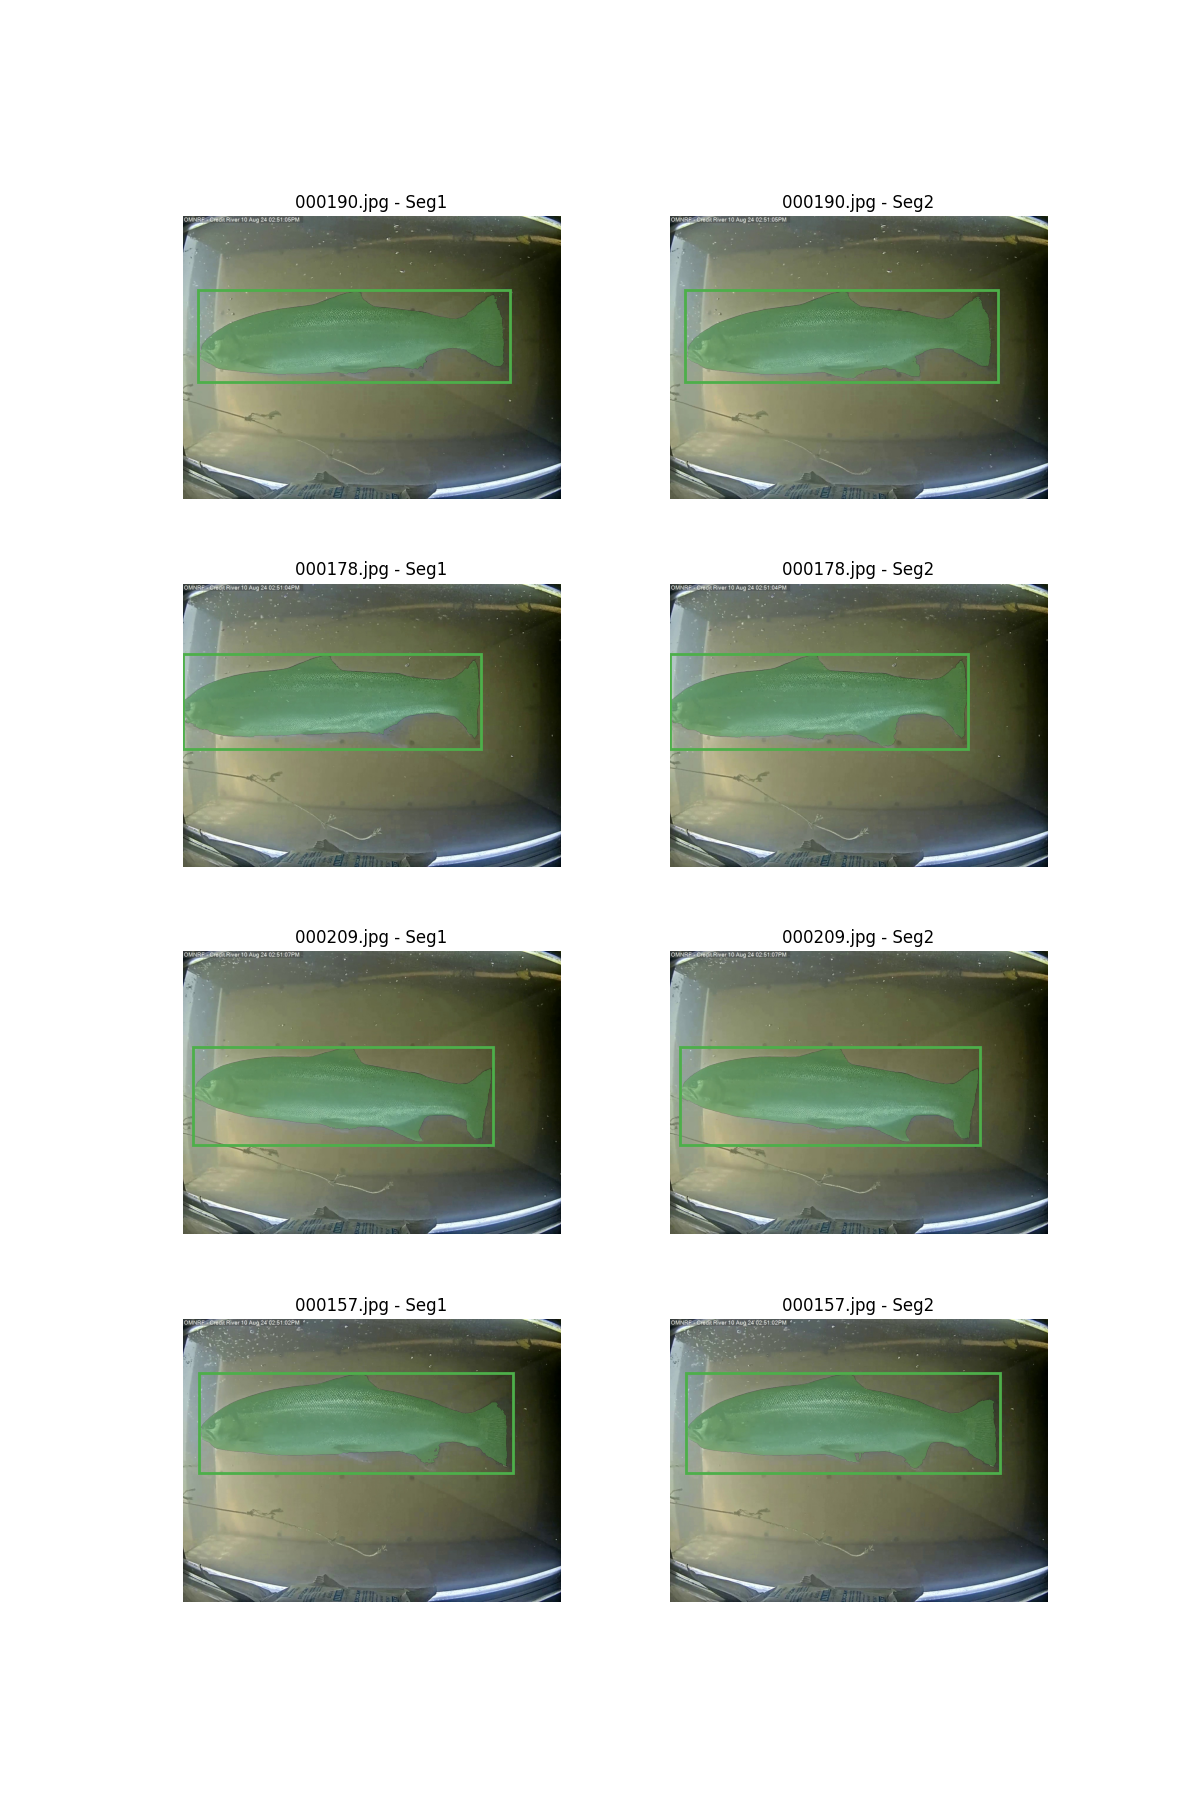

In [207]:
## Plot masks before and after click promts
# Choose 
start_frame = 77
image_ids = sorted(image_id_to_data.keys())
random_ids = random.sample(image_ids[start_frame:], 4)

# Maps for fast lookup
annotations_by_image1 = {}
annotations_by_image2 = {}

for ann in coco_box['annotations']:
    annotations_by_image1.setdefault(ann['image_id'], []).append(ann)

for ann in coco_click['annotations']:
    annotations_by_image2.setdefault(ann['image_id'], []).append(ann)

# Load categories
cat_id_to_name = {cat['id']: cat['name'] for cat in coco_box['categories']}
categories = list(cat_id_to_name.values())
cmap = plt.get_cmap("Set1")
cat_to_color = {name: cmap(i % cmap.N) for i, name in enumerate(sorted(categories))}

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 18))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for i, image_id in enumerate(random_ids):
    image_info = image_id_to_data[image_id]
    file_path = os.path.join(image_dir, image_info['file_name'])
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    anns1 = annotations_by_image1.get(image_id, [])
    anns2 = annotations_by_image2.get(image_id, [])

    for j, anns in enumerate([anns1, anns2]):
        ax = axes[i, j]
        ax.imshow(image)
        ax.set_title(f"{image_info['file_name']} - Seg{j+1}")
        ax.axis('off')

        for ann in anns:
            cat_id = ann['category_id']
            cat_name = cat_id_to_name.get(cat_id, str(cat_id))
            color = cat_to_color[cat_name]

            # Bounding box
            x, y, w, h = ann['bbox']
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # Mask
            if 'segmentation' in ann:
                rle = ann['segmentation']
                mask = decode_rle(rle)
                ax.imshow(np.ma.masked_where(mask == 0, mask), cmap=mcolors.ListedColormap([color]), alpha=0.4)

plt.show()

In [203]:
## Function to plot one mask
def plot_mask_on_image(rle_mask, alpha=0.5):
    decoded_mask = mask_utils.decode({
        'size': rle_mask['size'],
        'counts': bytes(rle_mask['counts']) if isinstance(rle_mask['counts'][0], int) else rle_mask['counts']
    })

    plt.figure(figsize=(10, 8))
    plt.imshow(decoded_mask, cmap='jet', alpha=alpha)
    plt.axis('off')
    plt.title("Mask over image")
    plt.show()

In [ ]:
plot_mask_on_image(coco_click["annotations"][0]["segmentation"])

### Code from using Predict function instead of add_points function

In [ ]:
# Use GPU if available, otherwise use CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Load the SAM model
sam_checkpoint = "/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/sam_vit_h_4b8939.pth"  # SAM checkpoint file
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


In [ ]:
# Prepare to collect updated segmentations
for ann in tqdm(coco["annotations"]):
    # Get corresponding image info
    image_info = image_id_to_data[ann["image_id"]]
    image_path = os.path.join("/Users/simone/Documents/UofT MSc/LO_Fishway_Labelling/Fishway_Data/coho_brow_trout/images/default", image_info["file_name"])  # Adjust if needed

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run SAM2
    predictor.set_image(image)

    # Convert COCO bbox (x, y, width, height) → SAM format (x0, y0, x1, y1)
    x, y, w, h = ann["bbox"]
    box = np.array([[x, y, x + w, y + h]])

    # Predict the mask
    masks, _, _ = predictor.predict(box=box, multimask_output=False)

    # Convert binary mask to RLE
    binary_mask = masks[0]
    rle = mask_utils.encode(np.asfortranarray(binary_mask.astype(np.uint8)))
    rle["counts"] = rle["counts"].decode("utf-8")  # Make JSON serializable

    # Add to annotation
    ann["segmentation"] = rle
    ann["iscrowd"] = 0  # Required when using RLE format

100%|██████████| 145/145 [07:56<00:00,  3.29s/it]


### Code from trying to propagate masks

In [ ]:
object_ids = inference_state['obj_ids']
output_scores_per_object = defaultdict(dict)
for object_id in object_ids:
    # add those input masks to SAM 2 inference state before propagation
    input_frame_inds = sorted(inputs_per_object[object_id])
    predictor.reset_state(inference_state)
    for input_frame_idx in input_frame_inds:
        predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=input_frame_idx,
            obj_id=object_id,
            mask=inputs_per_object[object_id][input_frame_idx],
        )

    # run propagation throughout the video and collect the results in a dict
    for out_frame_idx, _, out_mask_logits in predictor.propagate_in_video(
        inference_state,
        start_frame_idx=min(input_frame_inds),
        reverse=False,
    ):
        obj_scores = out_mask_logits.cpu().numpy()
        output_scores_per_object[object_id][out_frame_idx] = obj_scores

In [123]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(jpeg_folder)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

In [ ]:
# Do video segmentation (same as video segmentation notebook)
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    print(out_obj_ids)
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() 
        for i, out_obj_id in enumerate(out_obj_ids)
    }

In [ ]:
# render the segmentation results every few frames
vis_frame_stride = 5
plt.close("all")
for out_frame_idx in range(79, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(jpeg_folder, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

### Old code from trying to decompress RLE

In [4]:
def decode_uncompressed_rle(rle):
    counts = rle['counts']
    height, width = rle['size']
    
    total_pixels = height * width
    flat_mask = np.zeros(total_pixels, dtype=np.uint8)

    idx = 0
    val = 0
    for count in counts:
        if idx + count > total_pixels:
            break  # avoid overflow in malformed masks
        flat_mask[idx:idx+count] = val
        idx += count
        val = 1 - val  # flip between background (0) and mask (1)

    mask = flat_mask.reshape((height, width), order='F')  # column-major
    return mask


In [ ]:
def decompress_rle_string(rle_str, size):
    """
    Convert compressed RLE (weird string) to uncompressed RLE (list of pixels).
    """
    # Step 1: Decode compressed RLE string to binary mask
    rle = {
        'counts': rle_str.encode('utf-8'),  # IMPORTANT: must be bytes
        'size': size
    }
    mask = mask_utils.decode(rle)  # (H, W) binary mask

    # Step 2: Re-encode to uncompressed RLE
    encoded = mask_utils.encode(np.asfortranarray(mask))  # returns compressed by default

    # Extract counts — will still be bytes, so decode if needed
    counts = encoded['counts']
    if isinstance(counts, bytes):
        # This is still compressed — decode to mask again
        mask = mask_utils.decode(encoded)
        # Re-encode again and access decoded 'counts'
        counts_list = list(mask_utils.encode(np.asfortranarray(mask))['counts'])  # now decoded
    else:
        counts_list = list(counts)

    return {
        'counts': counts_list,
        'size': size
    }


In [ ]:
def single_mask_to_rle(mask):
    rle = mask_utils.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

In [103]:
def fix_broken_rle(rle):
    rle = rle.copy()
    counts = rle["counts"]

    # Remove the "b'" prefix and trailing "'" and re-encode
    if isinstance(counts, str) and counts.startswith("b'"):
        counts = counts[2:-1]  # strip b'...'
        rle["counts"] = counts.encode('utf-8')
    
    return rle

def make_rle_json_safe(rle):
    rle = rle.copy()
    if isinstance(rle["counts"], bytes):
        rle["counts"] = rle["counts"].decode("utf-8")
    return rle



### Test YTVIS stuff

In [3]:
with open("/Users/simone/Documents/UofT MSc/YTVIS2021/train/instances.json", "r") as f:
    ytvis_train = json.load(f)

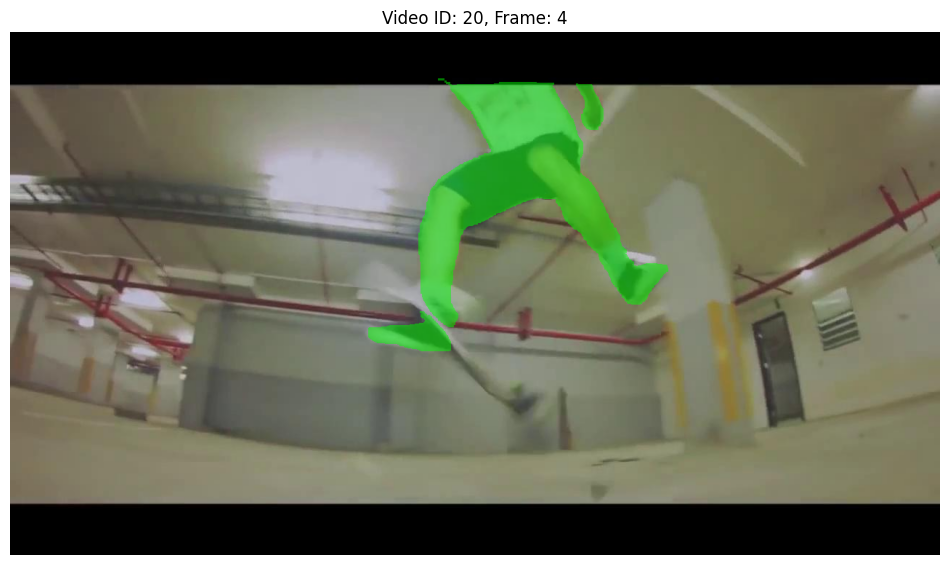

In [9]:
# === SETTINGS ===
ytvis_json_path = "/Users/simone/Documents/UofT MSc/YTVIS2021/train/instances.json"
ytvis_video_frames_root = '/Users/simone/Documents/UofT MSc/YTVIS2021/train/JPEGImages'  # subfolder per video
ytvis_video_id = 20
ytvis_frame_idx = 4  # Index of the frame in the video

ytvis_videos = {v['id']: v for v in ytvis_train['videos']}
#ytvis_images = ytvis_data['images']
ytvis_annotations = ytvis_train['annotations']
ytvis_categories = {cat['id']: cat['name'] for cat in ytvis_train['categories']}

# === VIDEO & FRAME INFO ===
ytvis_video_info = ytvis_videos[ytvis_video_id]
ytvis_frame_file = ytvis_video_info['file_names'][ytvis_frame_idx]
ytvis_frame_path = os.path.join(ytvis_video_frames_root, ytvis_frame_file)
ytvis_img = cv2.imread(ytvis_frame_path)
ytvis_img = cv2.cvtColor(ytvis_img, cv2.COLOR_BGR2RGB)

overlay = ytvis_img.copy()

# === DRAW RLE MASKS ===
for ann in ytvis_annotations:
    if ann['video_id'] != ytvis_video_id:
        continue

    seg = ann['segmentations'][ytvis_frame_idx]
    if seg is None:
        continue

    mask = decode_uncompressed_rle(seg)
    mask = mask if mask.ndim == 2 else mask[:, :, 0]

    color = np.array([0, 255, 0], dtype=np.uint8)  # or any RGB color

    # Apply overlay
    overlay[mask > 0] = (0.5 * overlay[mask > 0] + 0.5 * color).astype(np.uint8)

# === PLOT ===
plt.figure(figsize=(12, 8))
plt.imshow(overlay)
plt.title(f"Video ID: {ytvis_video_id}, Frame: {ytvis_frame_idx}")
plt.axis('off')
plt.show()

In [ ]:
def plot_mask_on_image(rle_mask, alpha=0.5):
    decoded_mask = mask_utils.decode({
        'size': rle_mask['size'],
        'counts': bytes(rle_mask['counts']) if isinstance(rle_mask['counts'][0], int) else rle_mask['counts']
    })

    plt.figure(figsize=(10, 8))
    plt.imshow(decoded_mask, cmap='jet', alpha=alpha)
    plt.axis('off')
    plt.title("Mask over image")
    plt.show()


In [ ]:
uncompressed_rle =subset_coco[23]["segmentation"]
print(uncompressed_rle)

{'size': [960, 1280], 'counts': [81, 109, 82, 98, 48, 56, 102, 109, 48, 53, 94, 82, 79, 68, 88, 109, 48, 101, 48, 77, 50, 77, 51, 78, 51, 77, 51, 77, 55, 73, 59, 69, 51, 77, 50, 78, 49, 79, 50, 79, 49, 78, 50, 78, 49, 79, 50, 78, 50, 78, 49, 48, 49, 78, 50, 78, 49, 79, 50, 79, 48, 79, 49, 79, 49, 79, 50, 79, 48, 79, 50, 79, 48, 79, 50, 79, 48, 79, 50, 78, 49, 48, 49, 78, 49, 48, 49, 78, 49, 79, 50, 79, 48, 79, 50, 79, 48, 79, 49, 48, 49, 78, 49, 48, 49, 78, 49, 79, 50, 79, 48, 79, 49, 48, 49, 78, 49, 48, 48, 79, 50, 79, 48, 79, 50, 79, 48, 79, 49, 48, 49, 78, 49, 79, 50, 78, 49, 48, 48, 79, 50, 79, 48, 79, 50, 79, 48, 79, 49, 48, 49, 78, 49, 48, 48, 79, 49, 79, 49, 48, 49, 78, 49, 48, 48, 79, 49, 48, 49, 78, 49, 48, 48, 79, 50, 79, 48, 79, 49, 48, 48, 79, 50, 79, 48, 79, 49, 48, 48, 79, 49, 48, 49, 78, 49, 48, 48, 79, 49, 48, 49, 78, 49, 48, 48, 79, 49, 48, 49, 79, 48, 79, 50, 79, 48, 48, 48, 79, 49, 79, 49, 48, 48, 79, 49, 79, 49, 48, 48, 79, 49, 48, 48, 79, 50, 79, 48, 79, 49, 48, 48

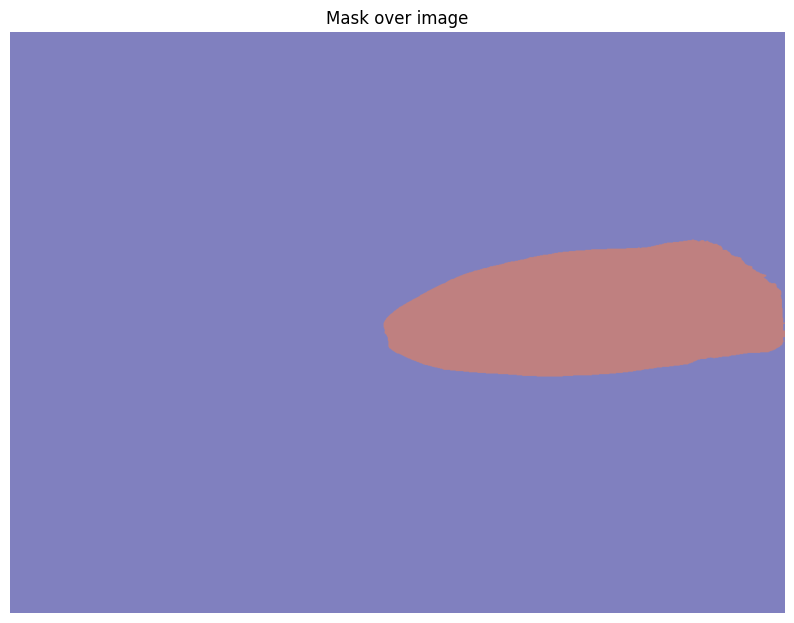

In [ ]:
plot_mask_on_image(uncompressed_rle, alpha=0.5)